# Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration

In [4]:
class Config:
    SEED = 42
    BATCH_SIZE = 32
    LR = 1e-4
    EPOCHS = 30
    IMAGE_SIZE = 224
    NUM_CLASSES = 10
    MODEL_SAVE_PATH = "best_model.pt"
    USE_CNN = True  # True for CNN, False for Transformer

    # Paths to both datasets
    PADDY_DATA_DIR = "/kaggle/input/paddy-disease-classification"
    MEND_DATA_DIR = "/kaggle/input/rice-leaf-dataset/Rice Leaf Disease Images"



In [5]:
# Fix seed
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(Config.SEED)

In [6]:
# Mendeley folder => standard_name
MENDELEY_NAME_MAP = {
    "Bacterialblight": "bacterial_leaf_blight",
    "Blast": "blast",
    "Brownspot": "brown_spot",
    "Tungro": "tungro"
}

# Data preparation

In [7]:
def gather_paddy_df(paddy_data_dir):
    """
    For the Paddy dataset, if we have train.csv with columns: [image_id, label, variety, age],
    and the images are in train_images/<label>/<image_id>.jpg
    """
    df = pd.read_csv(os.path.join(paddy_data_dir, "train.csv"))
    
    image_paths = []
    labels = []
    for idx, row in df.iterrows():
        image_id = row["image_id"]
        label = row["label"]  # e.g., "blast", "bacterial_blight", etc.
        # Construct full path
        path = os.path.join(paddy_data_dir, "train_images", label, f"{image_id}")
        image_paths.append(path)
        labels.append(label)
    
    paddy_df = pd.DataFrame({"image_path": image_paths, "label": labels})
    return paddy_df

def gather_mendeley_df(mend_data_dir):
    """
    We'll unify class names with MENDELEY_NAME_MAP.
    """
    image_paths = []
    labels = []
    # Each folder is a separate class
    for folder_name in os.listdir(mend_data_dir):
        folder_path = os.path.join(mend_data_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue  # skip any non-folder

        # Convert folder_name to standardized label
        if folder_name in MENDELEY_NAME_MAP:
            label = MENDELEY_NAME_MAP[folder_name]
        else:
            # If it's not in the map, we can keep it as is or skip
            label = folder_name.replace(" ", "_").lower()

        # Gather all images inside
        for fname in os.listdir(folder_path):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(folder_path, fname)
                image_paths.append(image_path)
                labels.append(label)
    
    mend_df = pd.DataFrame({"image_path": image_paths, "label": labels})
    return mend_df

paddy_df = gather_paddy_df(Config.PADDY_DATA_DIR)
mend_df = gather_mendeley_df(Config.MEND_DATA_DIR)

# Combine them:
combined_df = pd.concat([paddy_df, mend_df], axis=0).reset_index(drop=True)
print("Combined dataset size:", len(combined_df))

Combined dataset size: 16339


In [8]:
# Determine all classes
all_labels = sorted(combined_df['label'].unique().tolist())
label2idx = {lab: idx for idx, lab in enumerate(all_labels)}
idx2label = {v: k for k, v in label2idx.items()}

print("All classes (merged):", all_labels)
print("Number of total classes:", len(all_labels))

Config.NUM_CLASSES = len(all_labels)


All classes (merged): ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
Number of total classes: 10


In [9]:
class CombinedLeafDataset(Dataset):
    def __init__(self, df, label2idx, transform=None):
        self.df = df
        self.label2idx = label2idx
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label_str = row["label"]
        label_idx = self.label2idx[label_str]
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, label_idx


In [10]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Split into train and validation sets
train_df, val_df = train_test_split(
    combined_df,
    test_size=0.2,   # 80/20 split
    stratify=combined_df['label'],
    random_state=Config.SEED
)

train_dataset = CombinedLeafDataset(train_df, label2idx, transform=train_transform)
val_dataset   = CombinedLeafDataset(val_df, label2idx, transform=val_transform)

train_loader = DataLoader(train_dataset, 
                          batch_size=Config.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=2)
val_loader = DataLoader(val_dataset, 
                        batch_size=Config.BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=2)

print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))


Train dataset size: 13071
Val dataset size: 3268


# Models


In [11]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load a pretrained EfficientNet-B0
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers first (we'll unfreeze later in TrainerCNN)
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        # Replace final linear layer
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        in_features = self.model.head.in_features
        # Replace classifier head
        self.model.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [13]:
class TrainerCNN:
    """
    A trainer specifically for the CNN model,
    implementing partial-freezing logic and saving to 'MODEL_SAVE_PATH_CNN'.
    """
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        # Lists to store epoch-wise accuracy
        self.train_acc_history = []
        self.val_acc_history = []
        
        # 1) Label Smoothing in CrossEntropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # 2) Use Adam optimizer
        self.optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()), 
            lr=self.config.LR
        )
        
        # 3) Cosine Annealing LR scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, 
            T_max=self.config.EPOCHS
        )
        
        # partial-freezing
        self.freeze_epochs = getattr(self.config, "FREEZE_EPOCHS", 2)
        self.frozen = True
        
        # separate path for CNN
        self.model_save_path_cnn = "best_cnn.pt"

    def unfreeze_backbone(self):
        """Unfreeze all layers in the pretrained CNN backbone."""
        for param in self.model.model.parameters():
            param.requires_grad = True
        # Recreate optimizer now that backbone is trainable
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.LR)
        self.frozen = False
        print("CNN: Backbone layers are now unfrozen for fine-tuning.")

    def train_one_epoch(self, epoch):
        # Unfreeze after freeze_epochs
        if self.frozen and epoch == self.freeze_epochs:
            self.unfreeze_backbone()
        
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        self.train_acc_history.append(epoch_acc)   # <-- Store train accuracy
        print(f"[CNN Epoch {epoch+1}/{self.config.EPOCHS}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

    def validate(self, epoch):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        print(f"[CNN Epoch {epoch+1}/{self.config.EPOCHS}] "
              f"Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.2f}%")
        return epoch_acc
    
    def fit(self):
        best_acc = 0.0
        for epoch in range(self.config.EPOCHS):
            self.train_one_epoch(epoch)
            val_acc = self.validate(epoch)
            
            # Store val accuracy for this epoch
            self.val_acc_history.append(val_acc)   # <-- Store val accuracy

            self.scheduler.step()
            
            # Save best CNN
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), self.model_save_path_cnn)
                print(f"CNN Best model updated with Val Acc: {best_acc:.2f}%")
        
        # Return the recorded accuracy histories
        return self.train_acc_history, self.val_acc_history


In [14]:
class TrainerTransformer:
    """
    A trainer specifically for the Transformer model,
    with no partial-freezing logic.
    Saves to 'best_transformer.pt'.
    """
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        # Lists to store epoch-wise accuracy
        self.train_acc_history = []
        self.val_acc_history = []
        
        # 1) Label Smoothing in CrossEntropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # 2) Use Adam optimizer on all parameters
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.LR)
        
        # 3) Cosine Annealing LR scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=self.config.EPOCHS
        )
        
        # Separate path for the Transformer
        self.model_save_path_transformer = "best_transformer.pt"

    def train_one_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        
        # Store train accuracy
        self.train_acc_history.append(epoch_acc)
        
        print(f"[Transformer Epoch {epoch+1}/{self.config.EPOCHS}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

    def validate(self, epoch):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        
        print(f"[Transformer Epoch {epoch+1}/{self.config.EPOCHS}] "
              f"Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.2f}%")
        return epoch_acc
    
    def fit(self):
        best_acc = 0.0
        for epoch in range(self.config.EPOCHS):
            self.train_one_epoch(epoch)
            val_acc = self.validate(epoch)
            
            # Store val accuracy
            self.val_acc_history.append(val_acc)
            
            self.scheduler.step()
            
            # Save best Transformer
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), self.model_save_path_transformer)
                print(f"Transformer Best model updated with Val Acc: {best_acc:.2f}%")
        
        # Return the recorded accuracy histories
        return self.train_acc_history, self.val_acc_history

# Training

In [15]:
cnn_model = CNNModel(num_classes=Config.NUM_CLASSES)
trainer_cnn = TrainerCNN(cnn_model, train_loader, val_loader, Config)
cnn_train_acc, cnn_val_acc = trainer_cnn.fit()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 157MB/s]


[CNN Epoch 1/30] Train Loss: 1.9882, Train Acc: 40.51%
[CNN Epoch 1/30] Val Loss: 1.7869, Val Acc: 53.09%
CNN Best model updated with Val Acc: 53.09%
[CNN Epoch 2/30] Train Loss: 1.7074, Train Acc: 54.23%
[CNN Epoch 2/30] Val Loss: 1.5935, Val Acc: 58.05%
CNN Best model updated with Val Acc: 58.05%
CNN: Backbone layers are now unfrozen for fine-tuning.
[CNN Epoch 3/30] Train Loss: 1.0726, Train Acc: 77.43%
[CNN Epoch 3/30] Val Loss: 0.7544, Val Acc: 91.68%
CNN Best model updated with Val Acc: 91.68%
[CNN Epoch 4/30] Train Loss: 0.7442, Train Acc: 91.71%
[CNN Epoch 4/30] Val Loss: 0.6517, Val Acc: 95.01%
CNN Best model updated with Val Acc: 95.01%
[CNN Epoch 5/30] Train Loss: 0.6582, Train Acc: 95.27%
[CNN Epoch 5/30] Val Loss: 0.6085, Val Acc: 97.00%
CNN Best model updated with Val Acc: 97.00%
[CNN Epoch 6/30] Train Loss: 0.6219, Train Acc: 96.75%
[CNN Epoch 6/30] Val Loss: 0.5893, Val Acc: 97.80%
CNN Best model updated with Val Acc: 97.80%
[CNN Epoch 7/30] Train Loss: 0.5960, Train Ac

In [16]:
transformer_model = TransformerModel(num_classes=Config.NUM_CLASSES)
trainer_transformer = TrainerTransformer(transformer_model, train_loader, val_loader, Config)
trans_train_acc, trans_val_acc = trainer_transformer.fit()

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[Transformer Epoch 1/30] Train Loss: 1.0189, Train Acc: 78.30%
[Transformer Epoch 1/30] Val Loss: 0.7585, Val Acc: 89.72%
Transformer Best model updated with Val Acc: 89.72%
[Transformer Epoch 2/30] Train Loss: 0.7113, Train Acc: 91.78%
[Transformer Epoch 2/30] Val Loss: 0.6564, Val Acc: 93.85%
Transformer Best model updated with Val Acc: 93.85%
[Transformer Epoch 3/30] Train Loss: 0.6347, Train Acc: 95.16%
[Transformer Epoch 3/30] Val Loss: 0.6566, Val Acc: 94.40%
Transformer Best model updated with Val Acc: 94.40%
[Transformer Epoch 4/30] Train Loss: 0.6090, Train Acc: 96.01%
[Transformer Epoch 4/30] Val Loss: 0.6061, Val Acc: 95.81%
Transformer Best model updated with Val Acc: 95.81%
[Transformer Epoch 5/30] Val Loss: 0.5825, Val Acc: 96.94%
Transformer Best model updated with Val Acc: 96.94%
[Transformer Epoch 6/30] Train Loss: 0.5677, Train Acc: 97.61%
[Transformer Epoch 6/30] Val Loss: 0.5893, Val Acc: 97.37%
Transformer Best model updated with Val Acc: 97.37%
[Transformer Epoch 

In [17]:
def plot_accuracy_curves(
    cnn_train_acc, cnn_val_acc,
    trans_train_acc, trans_val_acc
):
    """
    Plots accuracy vs. epoch
    """
    epochs_cnn = range(1, len(cnn_train_acc) + 1)
    epochs_trans = range(1, len(trans_train_acc) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns
    
    # --- Left: CNN ---
    axes[0].plot(epochs_cnn, cnn_train_acc, label='Train Acc')
    axes[0].plot(epochs_cnn, cnn_val_acc, label='Val Acc')
    axes[0].set_title('CNN Accuracy vs. Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend()
    
    # --- Right: Transformer ---
    axes[1].plot(epochs_trans, trans_train_acc, label='Train Acc')
    axes[1].plot(epochs_trans, trans_val_acc, label='Val Acc')
    axes[1].set_title('Transformer Accuracy vs. Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    
    plt.show()

def plot_confusion_matrices(
    y_true_cnn, y_pred_cnn,
    y_true_trans, y_pred_trans,
    all_labels
):
    """
    Plots side-by-side confusion matrices for CNN (left) and Transformer (right).
    """
    cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn, labels=range(len(all_labels)))
    cm_trans = confusion_matrix(y_true_trans, y_pred_trans, labels=range(len(all_labels)))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # CNN Confusion Matrix
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels, ax=axes[0])
    axes[0].set_title("CNN Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    
    # Transformer Confusion Matrix
    sns.heatmap(cm_trans, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels, ax=axes[1])
    axes[1].set_title("Transformer Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    
    plt.show()

def print_classification_reports(
    y_true_cnn, y_pred_cnn,
    y_true_trans, y_pred_trans,
    all_labels
):
    """
    Prints classification reports (precision, recall, F1) for CNN and Transformer.
    """
    print("=== CNN Classification Report ===")
    print(classification_report(y_true_cnn, y_pred_cnn, target_names=all_labels, digits=4))
    
    print("\n=== Transformer Classification Report ===")
    print(classification_report(y_true_trans, y_pred_trans, target_names=all_labels, digits=4))


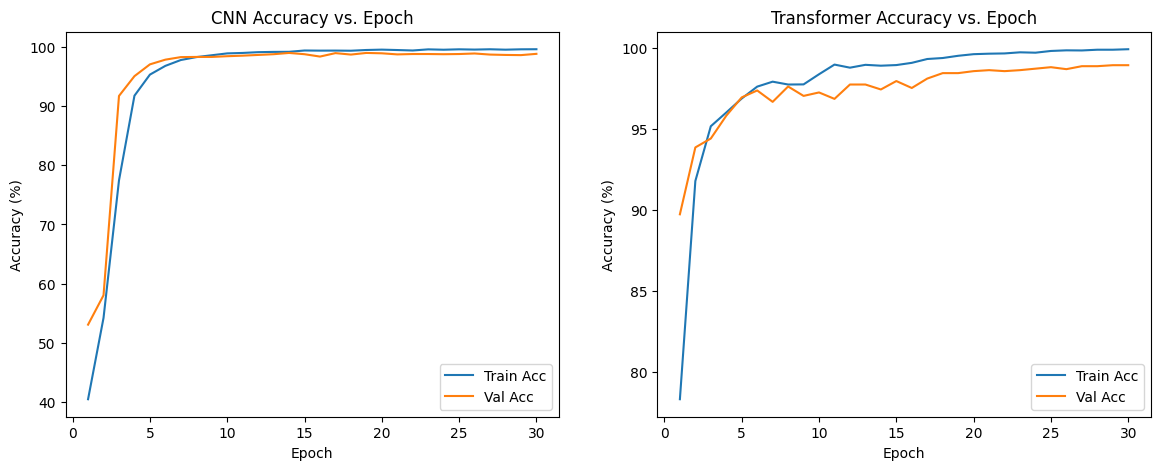

In [18]:
# Plot accuracy curves
plot_accuracy_curves(
    cnn_train_acc, cnn_val_acc,
    trans_train_acc, trans_val_acc
)

In [19]:
def get_preds_and_targets(model, data_loader, device):
    """
    Runs inference on 'data_loader' and returns two lists:
    1) preds: predicted class indices for each sample
    2) targets: ground-truth class indices for each sample
    """
    model.eval()  # set model to inference mode
    model.to(device)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)   # forward pass
            _, predicted = outputs.max(1)  # get indices of the max log-probability
            
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    
    return all_preds, all_targets


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = CNNModel(num_classes=Config.NUM_CLASSES)
cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))

transformer_model = TransformerModel(num_classes=Config.NUM_CLASSES)
transformer_model.load_state_dict(torch.load("best_transformer.pt", map_location=device))


cnn_preds, cnn_targets = get_preds_and_targets(cnn_model, val_loader, device)
trans_preds, trans_targets = get_preds_and_targets(transformer_model, val_loader, device)


<ipython-input-20-92ccb3f70075>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))
<ipython-input-20-

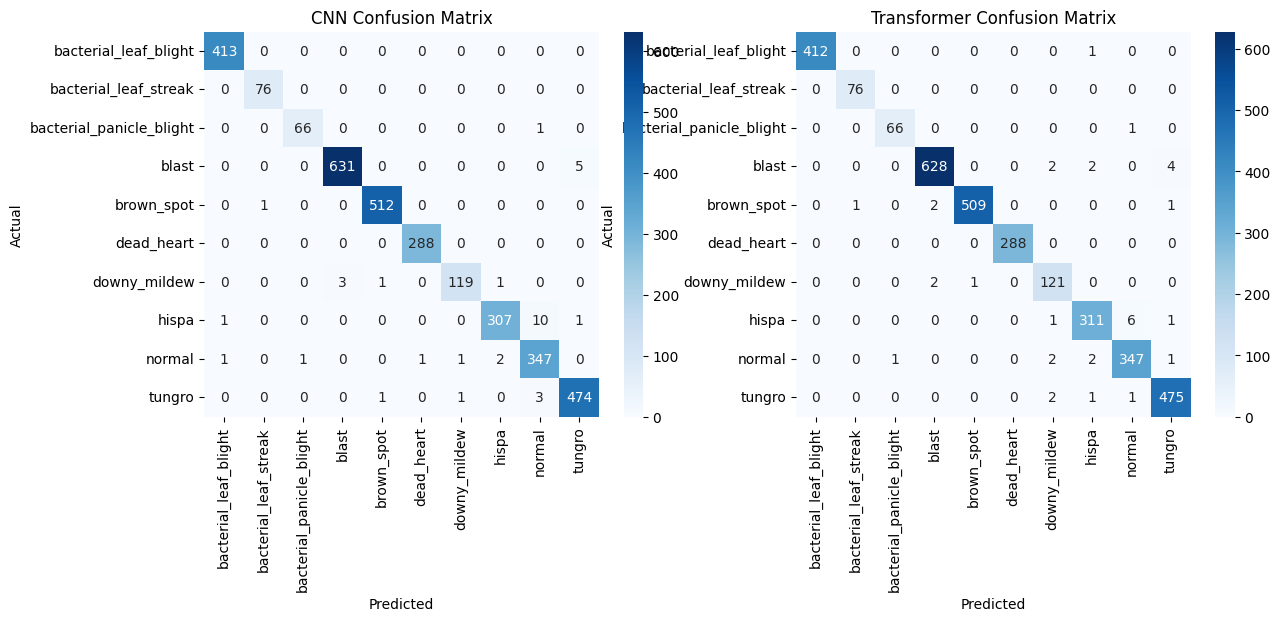

=== CNN Classification Report ===
                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.9952    1.0000    0.9976       413
   bacterial_leaf_streak     0.9870    1.0000    0.9935        76
bacterial_panicle_blight     0.9851    0.9851    0.9851        67
                   blast     0.9953    0.9921    0.9937       636
              brown_spot     0.9961    0.9981    0.9971       513
              dead_heart     0.9965    1.0000    0.9983       288
            downy_mildew     0.9835    0.9597    0.9714       124
                   hispa     0.9903    0.9624    0.9762       319
                  normal     0.9612    0.9830    0.9720       353
                  tungro     0.9875    0.9896    0.9885       479

                accuracy                         0.9893      3268
               macro avg     0.9878    0.9870    0.9873      3268
            weighted avg     0.9894    0.9893    0.9893      3268


=== Transformer Classification Report 

In [21]:
# Plot confusion matrices
plot_confusion_matrices(
    cnn_targets, cnn_preds,
    trans_targets, trans_preds,
    all_labels
)

# Print classification reports for each model
print_classification_reports(
    cnn_targets, cnn_preds,
    trans_targets, trans_preds,
    all_labels
)


# Testing

In [22]:
class PaddyTestDataset(torch.utils.data.Dataset):
    """
    A custom dataset for test images that have no labels.
    We'll output (image, image_id).
    """
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row["image_id"]
        # e.g., if test images are named "<image_id>.jpg"
        image_path = os.path.join(self.image_dir, image_id)
        
        img = Image.open(image_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        return img, image_id

In [23]:
# Load your test.csv
test_df = pd.read_csv(os.path.join(Config.PADDY_DATA_DIR, "sample_submission.csv")) 
test_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Build the test dataset & loader
test_dataset = PaddyTestDataset(
    df=test_df,
    image_dir=os.path.join(Config.PADDY_DATA_DIR, "test_images"),  # folder with images
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

In [24]:
# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# Load the best CNN model
cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))
cnn_model.eval()

# Inference on the test set
all_preds_cnn = []
image_ids = []

with torch.no_grad():
    for imgs, img_ids in test_loader:
        imgs = imgs.to(device)  # Move images to the same device as model
        
        # CNN predictions
        outputs_cnn = cnn_model(imgs)
        _, pred_cnn = outputs_cnn.max(1)
        
        all_preds_cnn.extend(pred_cnn.cpu().numpy())  # Move predictions to CPU
        image_ids.extend(img_ids)

# Convert numeric indices to label names
pred_labels_cnn = [idx2label[p] for p in all_preds_cnn]

# Ensure submission.csv follows the required format
submission1_df = pd.DataFrame({
    "image_id": image_ids,
    "label": pred_labels_cnn
})

# Save submission file
submission1_df.to_csv("submission1.csv", index=False)
print("submission1.csv created with CNN predictions only!")


<ipython-input-24-8657d92557af>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))


submission1.csv created with CNN predictions only!


In [26]:
transformer_model.to(device)

# Load the best Transformer model
transformer_model.load_state_dict(torch.load("best_transformer.pt", map_location=device))
transformer_model.eval()

all_preds_transformer = []
image_ids = []  # Reset image_ids to prevent duplication

with torch.no_grad():
    for imgs, img_ids in test_loader:
        imgs = imgs.to(device)  # Move images to device
        
        # Transformer predictions
        outputs_transformer = transformer_model(imgs)
        _, pred_trans = outputs_transformer.max(1)
        
        all_preds_transformer.extend(pred_trans.cpu().numpy())  # Convert to CPU
        image_ids.extend(img_ids)  # Ensure each prediction has a corresponding image ID

# Ensure both lists are of the same length
assert len(image_ids) == len(all_preds_transformer), "Mismatch between image IDs and predictions!"

# Convert numeric indices to labels
pred_labels_transformer = [idx2label[p] for p in all_preds_transformer]

# Create submission dataframe
submission2_df = pd.DataFrame({
    "image_id": image_ids,
    "label": pred_labels_transformer
})

# Save submission file
submission2_df.to_csv("submission2.csv", index=False)
print("submission2.csv created with transformer predictions only!")


<ipython-input-26-b5817571257f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model.load_state_dict(torch.load("best_transformer.pt", map_location=device))


submission2.csv created with transformer predictions only!


# Fine Tuning

In [27]:
def tune_cnn_hyperparams(model_class, train_loader, val_loader, config, lr_values=[1e-4, 3e-4, 1e-3]):
    """
    Simple grid search over learning rates for the CNN model.
    Returns (best_lr, best_accuracy).
    
    model_class:  e.g., CNNModel
    train_loader: DataLoader for training
    val_loader:   DataLoader for validation
    config:       your config object with EPOCHS, LR, etc.
    lr_values:    list of candidate learning rates
    """
    best_lr = None
    best_acc = 0.0
    
    original_lr = config.LR 
    
    for lr in lr_values:
        print(f"\n=== Testing LR = {lr} for CNN ===\n")
        
        config.LR = lr
        model = model_class(num_classes=config.NUM_CLASSES)
        trainer_cnn = TrainerCNN(model, train_loader, val_loader, config)
        
        # Train
        trainer_cnn.fit()
        
        # Evaluate on validation set using best checkpoint from this run
        tuned_model = model_class(num_classes=config.NUM_CLASSES)
        tuned_model.load_state_dict(torch.load("best_cnn.pt")) 
        tuned_model.eval()
        
        # Evaluate final accuracy 
        val_acc = evaluate_model_accuracy(tuned_model, val_loader)
        print(f"CNN with LR={lr} => Val Acc = {val_acc:.2f}%")
        
        # Keep track of best
        if val_acc > best_acc:
            best_acc = val_acc
            best_lr = lr
    
    config.LR = original_lr
    
    return best_lr, best_acc


In [28]:
def evaluate_model_accuracy(model, data_loader):
    """
    Returns accuracy (%) of 'model' on 'data_loader'.
    Assumes classification with outputs.max(1).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    
    return 100.0 * correct / total

In [33]:
# Some learning rates
candidate_lrs = [1e-5, 3e-5, 1e-4, 3e-4]
Config.EPOCHS = 15

In [34]:
# Tune CNN
best_lr_cnn, best_acc_cnn = tune_cnn_hyperparams(
    CNNModel,
    train_loader,
    val_loader,
    Config,
    lr_values=candidate_lrs
)
print(f"\nBest LR for CNN is {best_lr_cnn} with val_acc={best_acc_cnn:.2f}%")


=== Testing LR = 1e-05 for CNN ===

[CNN Epoch 1/15] Train Loss: 2.2666, Train Acc: 14.65%
[CNN Epoch 1/15] Val Loss: 2.2023, Val Acc: 23.10%
CNN Best model updated with Val Acc: 23.10%
[CNN Epoch 2/15] Train Loss: 2.1673, Train Acc: 24.71%
[CNN Epoch 2/15] Val Loss: 2.1345, Val Acc: 31.03%
CNN Best model updated with Val Acc: 31.03%
CNN: Backbone layers are now unfrozen for fine-tuning.
[CNN Epoch 3/15] Train Loss: 1.9088, Train Acc: 43.52%
[CNN Epoch 3/15] Val Loss: 1.6645, Val Acc: 56.76%
CNN Best model updated with Val Acc: 56.76%
[CNN Epoch 4/15] Train Loss: 1.5656, Train Acc: 59.39%
[CNN Epoch 4/15] Val Loss: 1.3656, Val Acc: 66.40%
CNN Best model updated with Val Acc: 66.40%
[CNN Epoch 5/15] Train Loss: 1.3234, Train Acc: 66.83%
[CNN Epoch 5/15] Val Loss: 1.1530, Val Acc: 73.26%
CNN Best model updated with Val Acc: 73.26%
[CNN Epoch 6/15] Train Loss: 1.1663, Train Acc: 72.40%
[CNN Epoch 6/15] Val Loss: 1.0324, Val Acc: 78.00%
CNN Best model updated with Val Acc: 78.00%
[CNN Epo

<ipython-input-27-f89807edd453>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tuned_model.load_state_dict(torch.load("best_cnn.pt"))  # "best_cnn.pt" is saved by trainer

CNN with LR=1e-05 => Val Acc = 94.31%

=== Testing LR = 3e-05 for CNN ===

[CNN Epoch 1/15] Train Loss: 2.1568, Train Acc: 25.93%
[CNN Epoch 1/15] Val Loss: 2.0710, Val Acc: 34.85%
CNN Best model updated with Val Acc: 34.85%
[CNN Epoch 2/15] Train Loss: 1.9897, Train Acc: 40.13%
[CNN Epoch 2/15] Val Loss: 1.9371, Val Acc: 44.77%
CNN Best model updated with Val Acc: 44.77%
CNN: Backbone layers are now unfrozen for fine-tuning.
[CNN Epoch 3/15] Train Loss: 1.4788, Train Acc: 61.97%
[CNN Epoch 3/15] Val Loss: 1.0902, Val Acc: 75.76%
CNN Best model updated with Val Acc: 75.76%
[CNN Epoch 4/15] Train Loss: 1.0421, Train Acc: 78.02%
[CNN Epoch 4/15] Val Loss: 0.8552, Val Acc: 87.15%
CNN Best model updated with Val Acc: 87.15%
[CNN Epoch 5/15] Train Loss: 0.8735, Train Acc: 86.14%
[CNN Epoch 5/15] Val Loss: 0.7448, Val Acc: 91.77%
CNN Best model updated with Val Acc: 91.77%
[CNN Epoch 6/15] Train Loss: 0.7838, Train Acc: 89.89%
[CNN Epoch 6/15] Val Loss: 0.6876, Val Acc: 93.82%
CNN Best model